# Check full Spectrum calibration  for no filter date 2023/01/17 PSF2DFFM for HD185975


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : January 24th 2023
- last update : January 27th 2023


# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle


In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/5as18041m_tmc.fits',
 'thermtable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [5]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [6]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack

In [7]:
# import libradtran
sys.path.append('../../../simulation/atmsim/libradtran')
import libsimulateVisible

libradtranpath= /Users/sylvie/MacOSX/External/libRadtran2/


In [8]:
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
class Line:
    """Class modeling the emission or absorption lines."""

    def __init__(self, wavelength, label, atmospheric=False, emission=False, label_pos=[0.007, 0.02],
                 width_bounds=[0.5, 6], use_for_calibration=False):
        """Class modeling the emission or absorption lines. lines attributes contains main spectral lines
        sorted in wavelength.

        Parameters
        ----------
        wavelength: float
            Wavelength of the spectral line in nm
        label: str

        atmospheric: bool
            Set True if the spectral line is atmospheric (default: False)
        emission: bool
            Set True if the spectral line has to be detected in emission. Can't be true if the line is atmospheric.
            (default: False)
        label_pos: [float, float]
            Position of the label in the plot with respect to the vertical lin (default: [0.007,0.02])
        width_bounds: [float, float]
            Minimum and maximum width (in nm) of the line for fitting procedures (default: [1,7])
        use_for_calibration: bool
            Use this line for the dispersion relation calibration, bright line recommended (default: False)

        Examples
        --------
        >>> l = Line(550, label='test', atmospheric=True, emission=True)
        >>> print(l.wavelength)
        550
        >>> print(l.label)
        test
        >>> print(l.atmospheric)
        True
        >>> print(l.emission)
        False
        """
        self.wavelength = wavelength  # in nm
        self.label = label
        self.label_pos = label_pos
        self.atmospheric = atmospheric
        self.emission = emission
        if self.atmospheric:
            self.emission = False
        self.width_bounds = width_bounds
        self.fitted = False
        self.use_for_calibration = use_for_calibration
        self.high_snr = False
        self.fit_lambdas = None
        self.fit_gauss = None
        self.fit_bgd = None
        self.fit_snr = None
        self.fit_fwhm = None
        self.fit_popt = None
        self.fit_pcov = None
        self.fit_popt_gaussian = None
        self.fit_pcov_gaussian = None
        self.fit_chisq = None
        self.fit_eqwidth_mod = None
        self.fit_eqwidth_data = None
        #self.fit_bgd_npar = parameters.CALIB_BGD_NPARAMS
        self.fit_bgd_npar = None


In [9]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

#my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
#hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
#hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
#oxygen_lines_order1 = Lines([O2_1,O2_2])

In [10]:
#ax.plot([x_O2_1,x_O2_1],[72,100],'b-',lw=3)
#ax.annotate(O2_1.label, xy=(x_O2_1, 80), color='b',fontsize=20,fontweight='bold')

# Functions

- filtering here

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [11]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [12]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [13]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [14]:
def GetSpectra(dict_spectra,factor=1.):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    #correction_area = 1.06/1.13
    correction_area = 1
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
    #for key, value in dict_spectra.items():
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]/ correction_area*factor 
        df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]/ correction_area*factor 
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [15]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra,factor = 1.):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    # factor to correct fluxes (over estimated collection surface)
    #correction_area = 1.06/1.13
    correction_area = 1
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    #for key, value in dict_spectra.items():
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]/correction_area*factor
            df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]/correction_area*factor
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [16]:
def FindPairOfExposures(df):
    """
    
    Find pair of exposures at similar airmass, one before culmination, the other one after the exposure
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """
    
    
 
    # the culmination  
    idx_zmin = df["airmass"].idxmin()
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[0:idx_zmin]
    
    # df after culmination
    df2 = df.iloc[idx_zmin+1:-1]
    
    #print(df1)
    
    #print(df2)
    
    # loop on exposure before culmination
    #for irow in range(0,idx_zmin):
        # print(irow,df1.iloc[irow][["number","airmass"]])
        
    dist = np.abs(df1["airmass"][np.newaxis, :] - df2["airmass"][:, np.newaxis])
    #print(dist)
    closest_idx = np.argmin(dist, axis=0)
    closest_id = df2.iloc[closest_idx]["number"].to_numpy()
    df_output = pd.DataFrame({"idx1": np.arange(0,idx_zmin), 
                              "idx2": closest_idx+idx_zmin+1,
                              "num1":df1["number"],
                              "num2":closest_id,
                              "z1":df1["airmass"].values,
                              "z2":df2.iloc[closest_idx]["airmass"].to_numpy()})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df2.iloc[closest_idx]["refhour"].to_numpy()- df1["refhour"] 
    return df_output
    

In [17]:
def FindPairOfExposuresFromFirst(df):
    """
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """ 
 

    idx_start = 0
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[:idx_start+1]
    
    # df after culmination
    df2 = df.iloc[idx_start+1:]
    N2=len(df2)
    

    df1_new = df1.copy(deep=True)
    df1_new = pd.concat([df1]*(N2),axis=0)
 
    df1=df1_new
    N1=len(df1)
   
    df_output = pd.DataFrame({"idx1": np.full(N1,0), 
                              "idx2": np.arange(1,N2+1),
                              "num1":df1["number"].values,
                              "num2":df2["number"].values,
                              "z1":df1["airmass"].values,
                              "z2":df2["airmass"].values,
                              "t1":df1["refhour"].values,
                              "t2":df2["refhour"].values})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df_output["t2"]-df_output["t1"]
    return df1,df2,df_output
    

# Constants

# Initialisation

In [18]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [19]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2023-01-27 15:28:59,358 imacdagoret.lal.in2p3.fr __main__[35856] INFO LA time:06:28:59
2023-01-27 15:28:59,360 imacdagoret.lal.in2p3.fr __main__[35856] INFO NY time:09:28:59
2023-01-27 15:28:59,362 imacdagoret.lal.in2p3.fr __main__[35856] INFO London time:14:28:59
2023-01-27 15:28:59,364 imacdagoret.lal.in2p3.fr __main__[35856] INFO Paris time:15:28:59
2023-01-27 15:28:59,364 imacdagoret.lal.in2p3.fr __main__[35856] INFO ************************ START *********************


In [20]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [21]:
!ls config

confprog_run-auxtel-20230117-empty~holo_psf2dffm-hd185975.ini
confprog_run-auxtel-20230117-empty~holo_psf2dffm-hd38666.ini
confprog_run-auxtel-20230118-empty~holo_psf2dffm-hd185975.ini
confprog_run-auxtel-20230118-empty~holo_psf2dffm-hd185975_b.ini
confprog_run-auxtel-20230118-empty~holo_psf2dffm-hd38666.ini
confprog_run-auxtel-20230118-empty~holo_psf2dffm-hd38666_b.ini
confprog_run-auxtel-20230119-empty~holo_psf2dffm-hd185975.ini
confprog_run-auxtel-20230119-empty~holo_psf2dffm-hd38666.ini
confprog_run-auxtel-20230119-empty~holo_psf2dffm-hd42525.ini
confprog_run-auxtel.ini


In [22]:
# config file
# --------------
#configfile = "config/default.ini"
configfile = "config/confprog_run-auxtel-20230117-empty~holo_psf2dffm-hd185975.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2023-01-27 15:28:59,502 imacdagoret.lal.in2p3.fr __main__[35856] INFO Configuration file : config/confprog_run-auxtel-20230117-empty~holo_psf2dffm-hd185975.ini


In [23]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2023-01-27 15:28:59,510 imacdagoret.lal.in2p3.fr __main__[35856] INFO 1) Configuration


In [24]:
config_section = config.sections()

In [25]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [26]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    filterdisperser =  config['GENERAL']['filterdisperser']
    
    
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    
    filename_auxtelthroughput = config['GENERAL']['filename_auxtelthroughput']
   
    spectractormode = config['GENERAL']['spectractormode']
   
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    
    
    MAGLIMMIN     = float(config['GENERAL']['MAGLIMMIN'])
    MAGLIMMAX     = float(config['GENERAL']['MAGLIMMAX'])
    FLUXLIMMIN    = float(config['GENERAL']['FLUXLIMMIN'])
    FLUXLIMMAX    = float(config['GENERAL']['FLUXLIMMAX'])    
    
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    inputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    inputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [27]:
msg=f" Object observed {target} at {SITE} ({DATE})"
logger.info(msg)

2023-01-27 15:28:59,530 imacdagoret.lal.in2p3.fr __main__[35856] INFO  Object observed HD185975 at AUXTEL/Rubin Obs (2023-01-17)


In [28]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [29]:
list_of_badnums1 = [int(nn)  for nn in BADEXPOS.split()]
list_of_badnums1

[348, 373, 245, 390, 473, 647, 376, 239, 334, 646, 552, 644, 645]

In [30]:
WL= np.arange(WLMINSEL,WLMAXSEL)

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [31]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.


In [32]:
sed_w=s0.wave/10
sed_f=s0.flux*10*normalisationfactor
sed_idx=np.where(np.logical_and(sed_w> WLMINSEL ,sed_w< WLMAXSEL))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [33]:
# interpolation function
f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")

In [34]:
targetname = s0.fheader['TARGETID']

In [35]:
sed_m=-2.5*np.log10(sed_f)

Text(0, 0.5, 'mag')

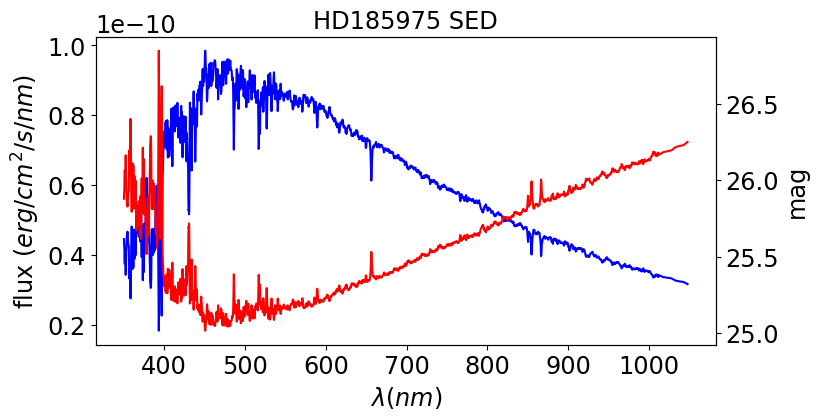

In [36]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.plot(sed_w,sed_f,'b')
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title(targetname + " SED")
ax2=ax.twinx()
ax2.plot(sed_w,sed_m,'r-')
ax2.set_ylabel("mag")

# Simulate the atmosphere

In [37]:
am       = 1.2
pressure = 0. # use default value
pwv      = 4.0
aer      = 0.1
ozone    = 300.
cloudext = 0

In [38]:
path,thefile=libsimulateVisible.ProcessSimulation(am,pwv,ozone,pressure,prof_str='us',proc_str='sa',cloudext=cloudext)
data = np.loadtxt(os.path.join(path,thefile))
wlsim = data[:,0]
atmsim = data[:,1] 

In [39]:
NBINSIM=len(wlsim)
NBINSIM

951

Text(0.5, 1.0, 'atmospheric transmission')

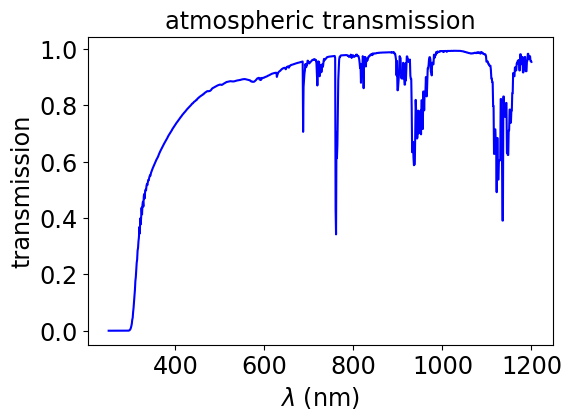

In [40]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(wlsim,atmsim,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_title("atmospheric transmission")

In [41]:
f_atm = interpolate.interp1d(wlsim,atmsim,bounds_error=False,fill_value="extrapolate")

# Throughputs

## Auxtel throughput and  telescope throughput

In [42]:
array = np.loadtxt(filename_auxtelthroughput)
dft = pd.DataFrame(data=array,columns=["lambda","throughput"])

In [43]:
#dft = pd.read_excel(filename_auxtelthroughput,header=1,index_col=0)
dft.reset_index(inplace=True)
dft['index'] = dft.reset_index().index
dft.set_index('index')
dft.rename(columns={'lambda':'lambdas'},inplace = True)

Text(0.5, 1.0, 'auxtel throughput')

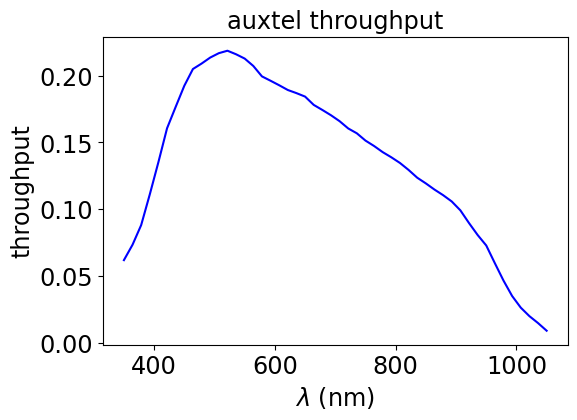

In [44]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(dft.lambdas,dft.throughput,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel throughput")

In [45]:
# interpolation function
f_thr = interpolate.interp1d(dft.lambdas,dft.throughput,bounds_error=False,fill_value="extrapolate")

## spectrum data

In [46]:
fullfilename=os.path.join(inputdir,inputfile)

In [47]:
!ls data

absorption_pattern.csv
run-auxtel-holo-20230117-empty~holo4_003-PSF2DFFM_REBIN2.pickle
run-auxtel-holo-20230117-empty~holo4_003-PSF2DFFM_REBIN2_b.pickle
run-auxtel-holo-20230118-empty~holo4_003-PSF2DFFM_REBIN2.pickle
run-auxtel-holo-20230118-empty~holo4_003-PSF2DFFM_REBIN2_b.pickle
run-auxtel-holo-20230119-empty~holo4_003-PSF2DFFM_REBIN2.pickle
run-auxtel-holo-20230119-empty~holo4_003-PSF2DFFM_REBIN2_b.pickle


In [48]:
with open(fullfilename, 'rb') as f:
    summary_content = pickle.load(f)

In [49]:
NBSPECTRA=len(summary_content)

In [50]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2023-01-27 15:29:07,804 imacdagoret.lal.in2p3.fr __main__[35856] INFO  Number of selected files is 71


In [51]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [52]:
normalisationfactor

4.0

In [53]:
infos, all_spectra = GetSpectra(summary_content,factor = normalisationfactor)

In [54]:
N=len(infos)

In [55]:
NX=4
NY=N/NX

In [56]:
if NY != int(NY):
    NY= int(NY)+1
else:
    NY=int(NY)

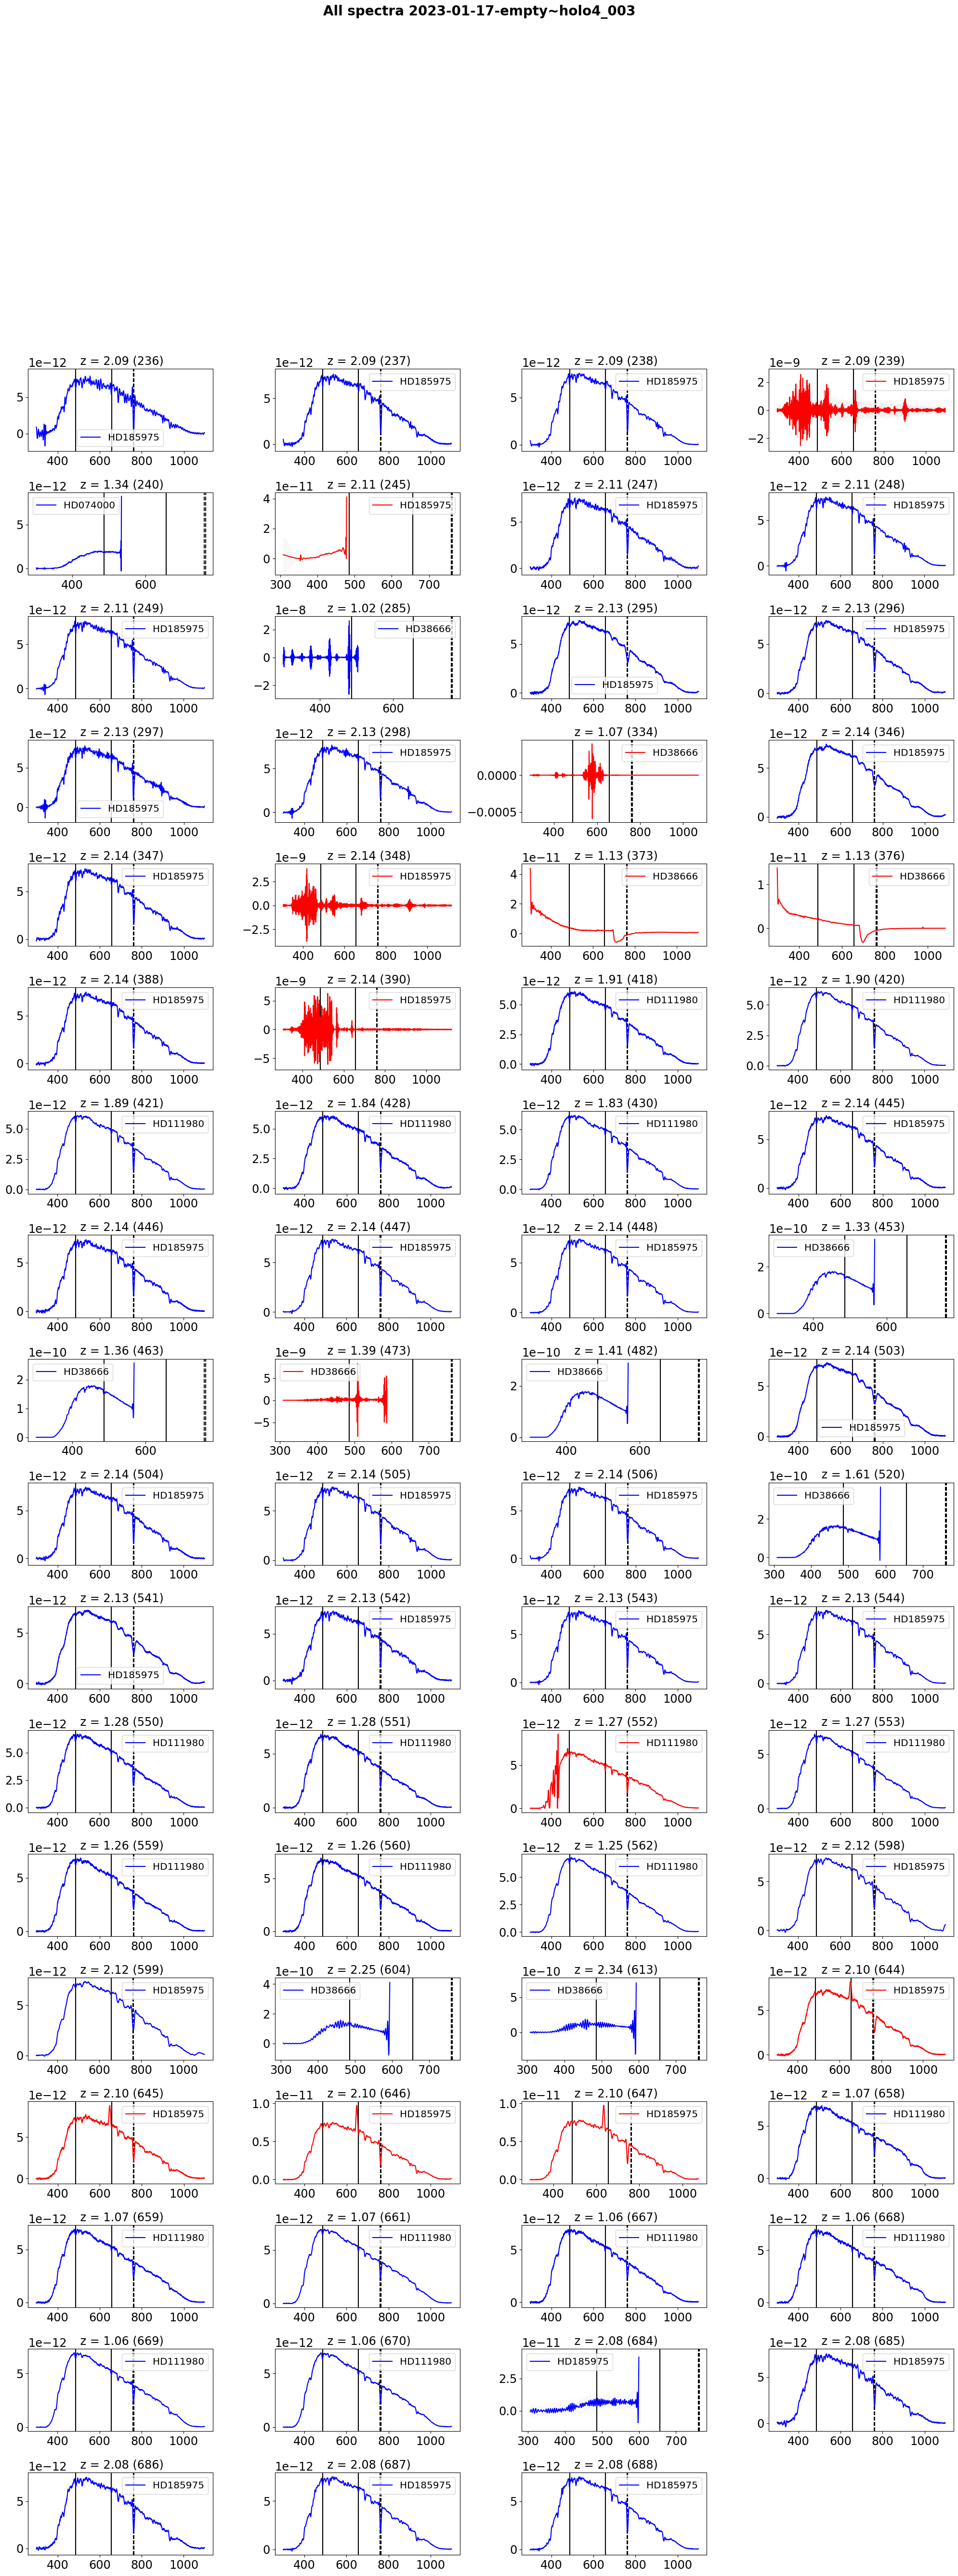

In [57]:
fig = plt.figure(figsize=(20,NY*3))

ny=0
nx=0

for idx in range(N):
    iy = idx//NX
    ix = (idx-iy*NX)
    
    ax=fig.add_subplot(NY,NX,idx+1)
    
    
    
    the_df=all_spectra[idx]
    
    airmassvalue = infos.iloc[idx]["airmass"]
    num = infos.iloc[idx]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    the_target = infos.iloc[idx]["object"]
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    if num in list_of_badnums1:
        thecolor="r"
    else:
        thecolor="b"
    
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-', color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
    ax.set_title(label_airmass)
    
    ax.axvline(HBETA.wavelength,linestyle="-",color="k")
    ax.axvline(HALPHA.wavelength,linestyle="-",color="k")
    
    # O2 line
    ax.axvline(O2_1.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.legend()
the_title = f"All spectra {DATE}-{filterdisperser}"
plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)
fig_filename = f"fig_01-{DATE}-{filterdisperser}-{target}.pdf"
plt.savefig(fig_filename)
plt.show()

# Remove bad Spectra

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_35856/813861976.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


[Text(0, 0, 'HD185975'),
 Text(1, 0, 'HD074000'),
 Text(2, 0, 'HD38666'),
 Text(3, 0, 'HD111980')]

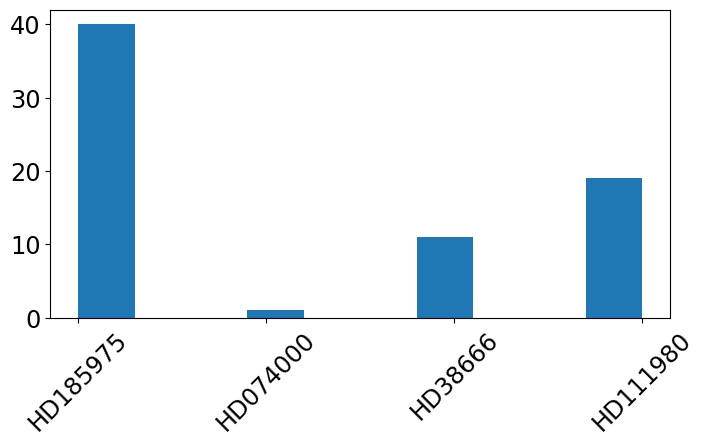

In [58]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')

Text(0.5, 0.98, 'Variables to apply selection')

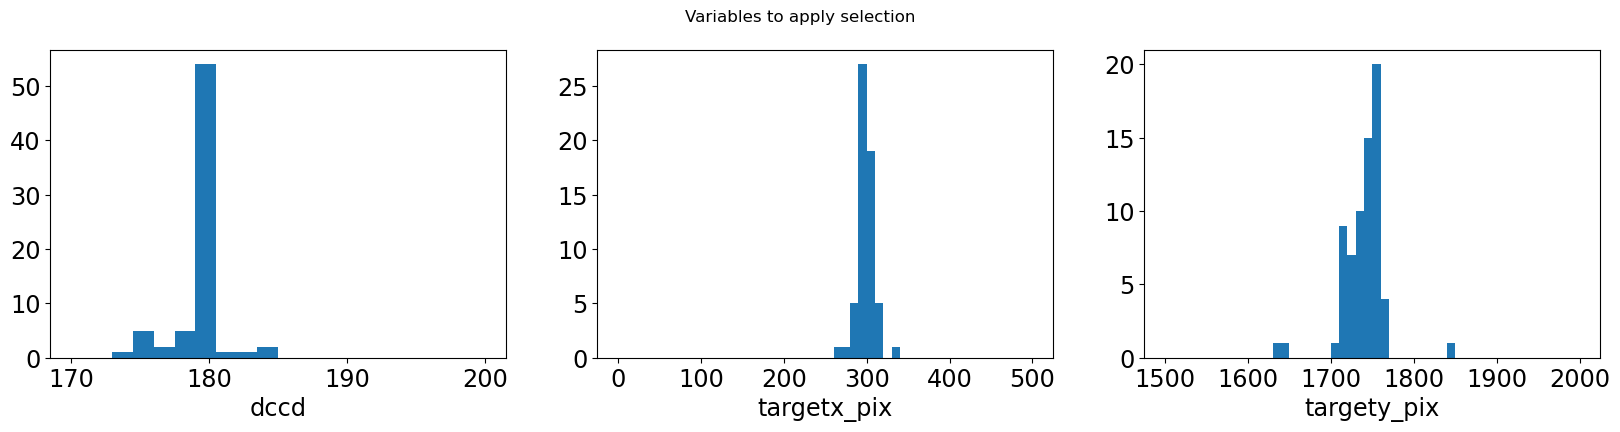

In [59]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.d2ccd,bins=20,range=(170,200));
ax.set_xlabel("dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.targetx_pix,bins=50,range=(0,500));
ax.set_xlabel("targetx_pix")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.targety_pix,bins=50,range=(1500,2000));
ax.set_xlabel("targety_pix")
plt.suptitle("Variables to apply selection")

## Define selection cut

In [60]:
selection_cut = ((infos.d2ccd > 178.5) & (infos.d2ccd < 181.5)) & (infos.object == target)
bad_cut = ~selection_cut

In [61]:
list_of_badnums2 = infos[bad_cut]["number"].values
list_of_badnums2 

array([240, 245, 285, 334, 348, 373, 376, 390, 418, 420, 421, 428, 430,
       453, 463, 473, 482, 520, 550, 551, 552, 553, 559, 560, 562, 604,
       613, 647, 658, 659, 661, 667, 668, 669, 670, 684])

# Union of badnums

In [62]:
list_of_badnums = np.union1d(list_of_badnums1,list_of_badnums2)
list_of_badnums=np.unique(list_of_badnums)

# Filtered spectra : remove bad spectra

In [63]:
list_of_badnums

array([239, 240, 245, 285, 334, 348, 373, 376, 390, 418, 420, 421, 428,
       430, 453, 463, 473, 482, 520, 550, 551, 552, 553, 559, 560, 562,
       604, 613, 644, 645, 646, 647, 658, 659, 661, 667, 668, 669, 670,
       684])

In [64]:
infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums,factor = normalisationfactor)

Remove spectrum 3 for exposure 239
Remove spectrum 4 for exposure 240
Remove spectrum 5 for exposure 245
Remove spectrum 9 for exposure 285
Remove spectrum 14 for exposure 334
Remove spectrum 17 for exposure 348
Remove spectrum 18 for exposure 373
Remove spectrum 19 for exposure 376
Remove spectrum 21 for exposure 390
Remove spectrum 22 for exposure 418
Remove spectrum 23 for exposure 420
Remove spectrum 24 for exposure 421
Remove spectrum 25 for exposure 428
Remove spectrum 26 for exposure 430
Remove spectrum 31 for exposure 453
Remove spectrum 32 for exposure 463
Remove spectrum 33 for exposure 473
Remove spectrum 34 for exposure 482
Remove spectrum 39 for exposure 520
Remove spectrum 44 for exposure 550
Remove spectrum 45 for exposure 551
Remove spectrum 46 for exposure 552
Remove spectrum 47 for exposure 553
Remove spectrum 48 for exposure 559
Remove spectrum 49 for exposure 560
Remove spectrum 50 for exposure 562
Remove spectrum 53 for exposure 604
Remove spectrum 54 for exposure 

In [65]:
print("Number of spectra : ",len(all_spectra))

Number of spectra :  31


In [66]:
infos.reset_index(drop=True, inplace=True)

In [67]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,236,HD185975,2023-01-18T02:32:55.079997036Z,-0.163236,2.093848,0,0,0,2023011700236,297.294239,1753.105985,0.470769,180.306015
1,237,HD185975,2023-01-18T02:33:13.842993330Z,-0.158024,2.094007,0,0,0,2023011700237,284.385053,1755.801032,0.489444,179.995230
2,238,HD185975,2023-01-18T02:33:44.320492641Z,-0.149558,2.094160,0,0,0,2023011700238,279.496998,1754.381492,0.464763,180.007966
3,247,HD185975,2023-01-18T03:04:42.971508069Z,0.366734,2.109507,0,0,0,2023011700247,283.403468,1750.344691,0.488684,179.993833
4,248,HD185975,2023-01-18T03:05:13.302506988Z,0.375159,2.109638,0,0,0,2023011700248,280.552699,1750.910686,0.469879,180.027568
5,249,HD185975,2023-01-18T03:05:56.221990758Z,0.387082,2.109952,0,0,0,2023011700249,283.691456,1748.170716,0.464353,179.939206
6,295,HD185975,2023-01-18T03:47:41.739007940Z,1.083058,2.125845,0,0,0,2023011700295,310.979244,1755.354778,0.482087,180.149575
7,296,HD185975,2023-01-18T03:47:59.894994204Z,1.088102,2.125943,0,0,0,2023011700296,315.376855,1759.644222,0.497625,180.105003
8,297,HD185975,2023-01-18T03:48:30.275498016Z,1.096541,2.126041,0,0,0,2023011700297,314.059490,1758.049958,0.469005,180.172144
9,298,HD185975,2023-01-18T03:49:13.267493074Z,1.108483,2.126274,0,0,0,2023011700298,314.115710,1754.015706,0.475745,180.119941


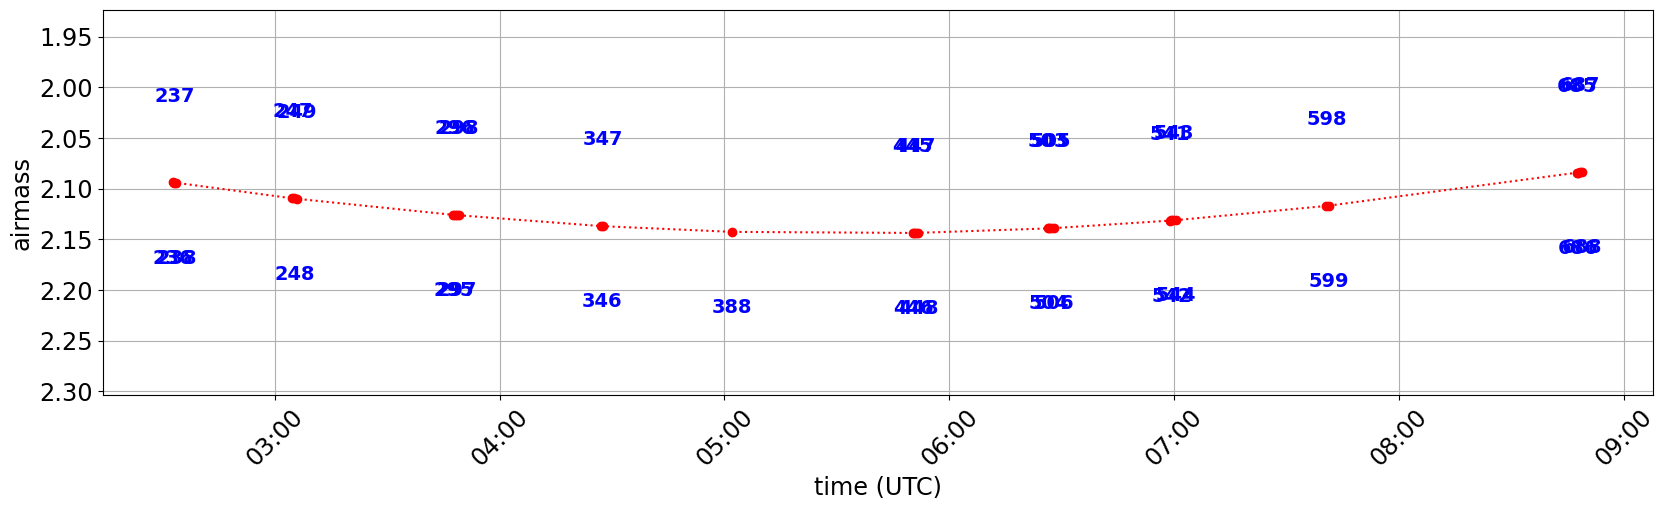

In [68]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['dateobs'] ]
numbers = infos['number'].values
airmasses = infos['airmass'].values
N= len(numbers)

myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)


# Create rectangle x coordinates
startTime = all_datetime[0]
endTime =  datetime(2022, 7, 1, 4, 0, 0, 0),

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start



fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(111)
#ax.plot(all_datetime,grey_attenuation,'bo:')
#ax.grid()
#plt.gcf().autofmt_xdate()
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_tick_params(rotation=45)
#ax.set_xlabel("time (UTC)")
#ax.set_title(f"Grey attenuation : {DATE} ({filterdisperser}, {target})")
#ax.set_ylabel("attenuation")
#ax2 = ax.twinx()

y_shift= 0.08

ax2=ax
ax2.plot(all_datetime,airmasses,'r:o')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.set_ylim(airmasses.min()-2*y_shift,airmasses.max()+2*y_shift)
# Plot rectangle
#rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
#ax2.add_patch(rect)   
ax2.invert_yaxis()
ax2.grid()


for index in range(N):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax2.text(all_datetime[index], airmasses[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    


# Plot Spectra

In [69]:
NBSPECTRA=len(all_spectra)

In [70]:
assert NBSPECTRA == len(infos)

In [71]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [72]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2023-01-27 15:29:29,210 imacdagoret.lal.in2p3.fr __main__[35856] INFO  Number of good spectra is 31


### load absorption pattern

In [73]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

In [74]:
def plotlines(ax,ypos):
    
    ax.axvline(HDELTA.wavelength,color='orange')
    ax.annotate(HDELTA.label, xy=(HDELTA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HGAMMA.wavelength,color='orange')
    ax.annotate(HGAMMA.label, xy=(HGAMMA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HBETA.wavelength,color='orange')
    ax.annotate(HBETA.label, xy=(HBETA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HALPHA.wavelength,color='orange')
    ax.annotate(HALPHA.label, xy=(HALPHA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')

    ax.axvline(O2B.wavelength,color="blue")
    ax.annotate(O2B.label, xy=(O2B.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_1.wavelength,color="blue")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,color="blue")
    ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(H2O_1.wavelength,color="blue")
    ax.annotate(H2O_1.label, xy=(H2O_1.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.axvline(H2O_2.wavelength,color="blue")
    ax.annotate(H2O_2.label, xy=(H2O_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    

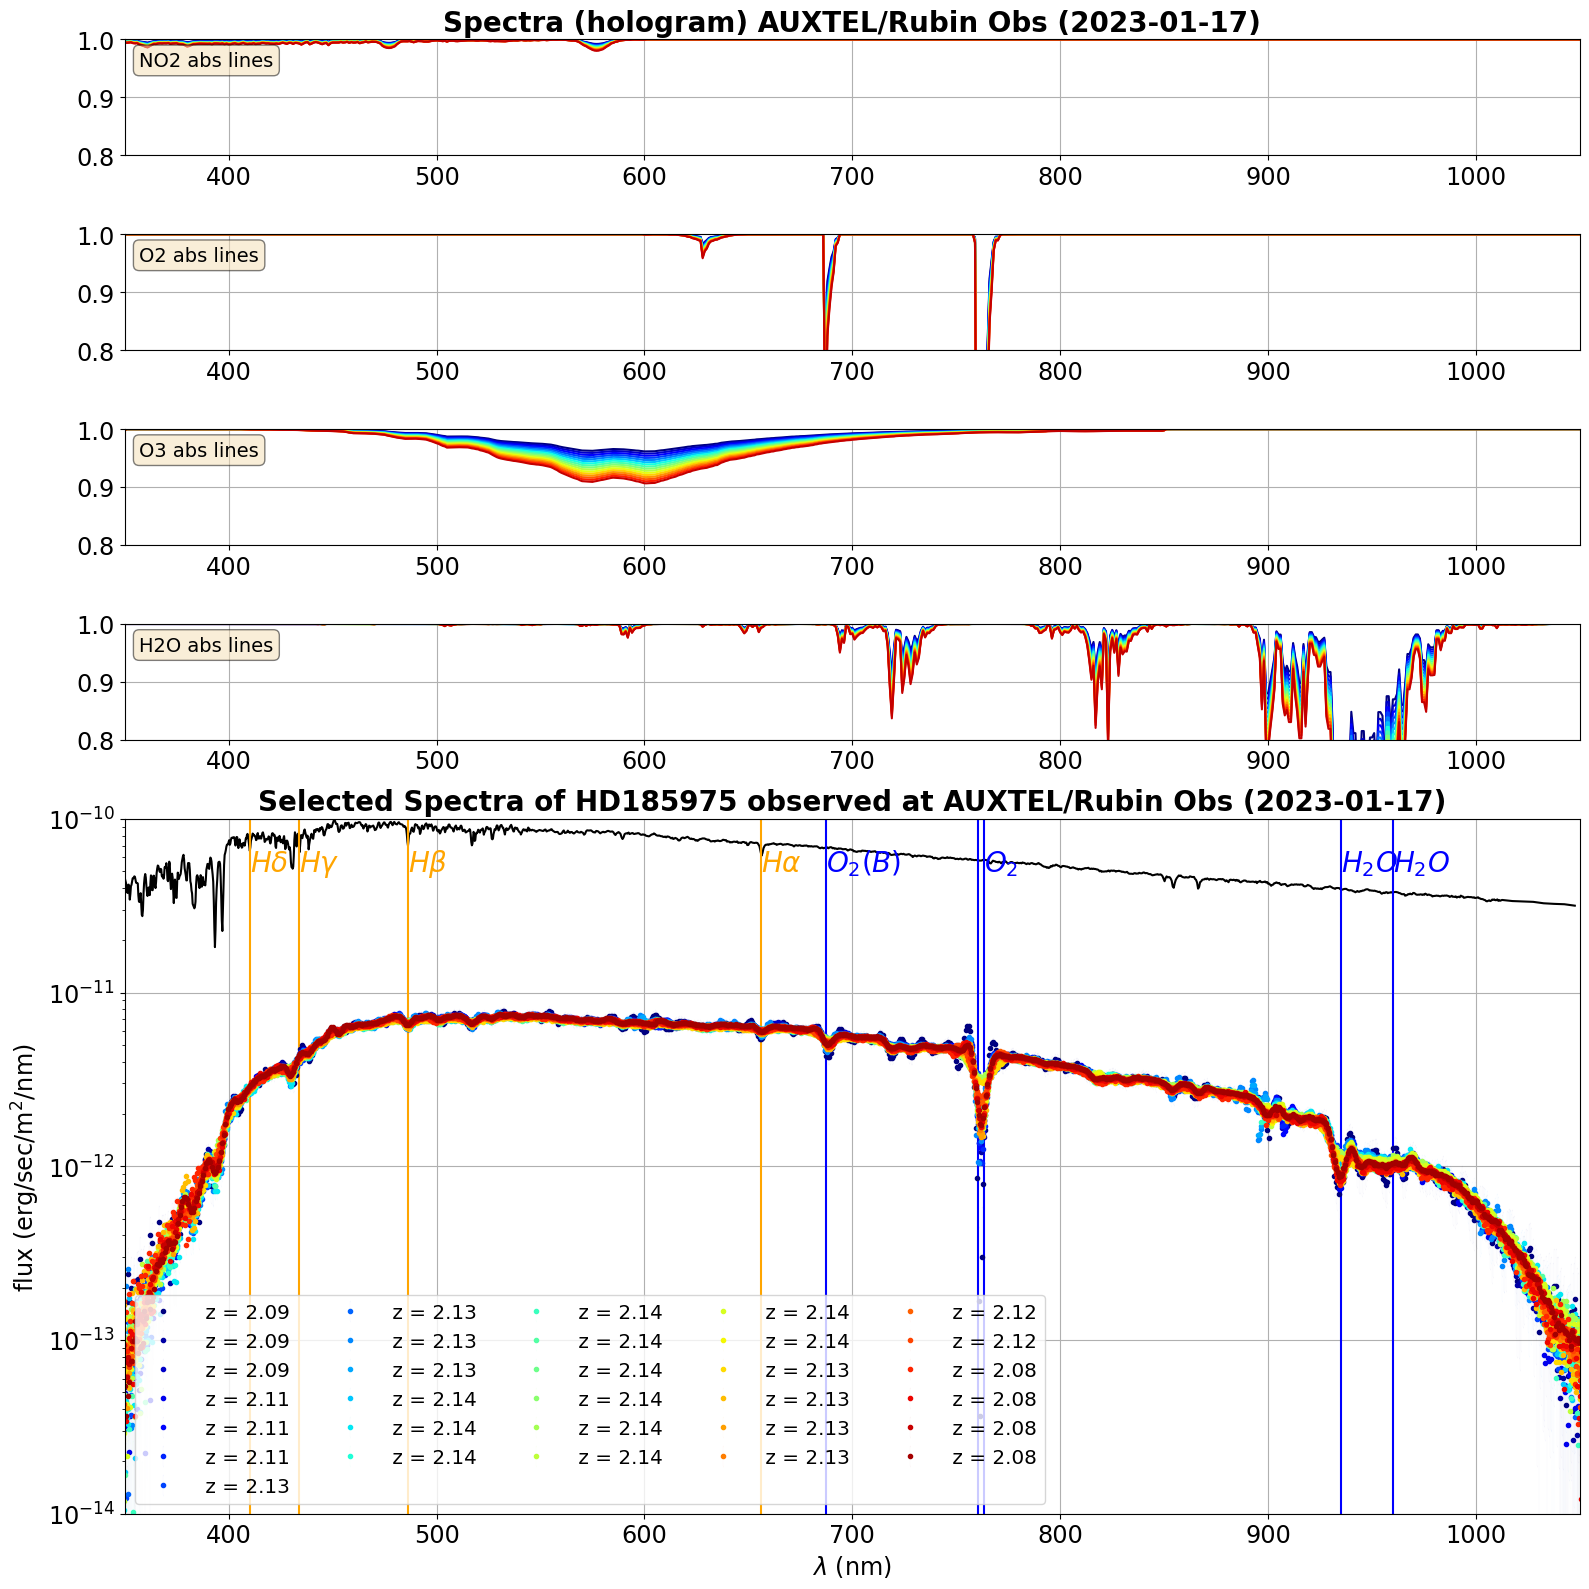

In [75]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,3] ,figure=fig)

# NO2    
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_title(title,fontsize=20,fontweight='bold')
main_ax = ax



# O2    
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)


# Ozone
ax=fig.add_subplot(gs[2,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# H2O
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# spectrum
ax=fig.add_subplot(gs[4,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
#ax.set_xlim(350,1000)
#ax.set_ylim(1e-14,1e-10)
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=5)

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)




plt.tight_layout()


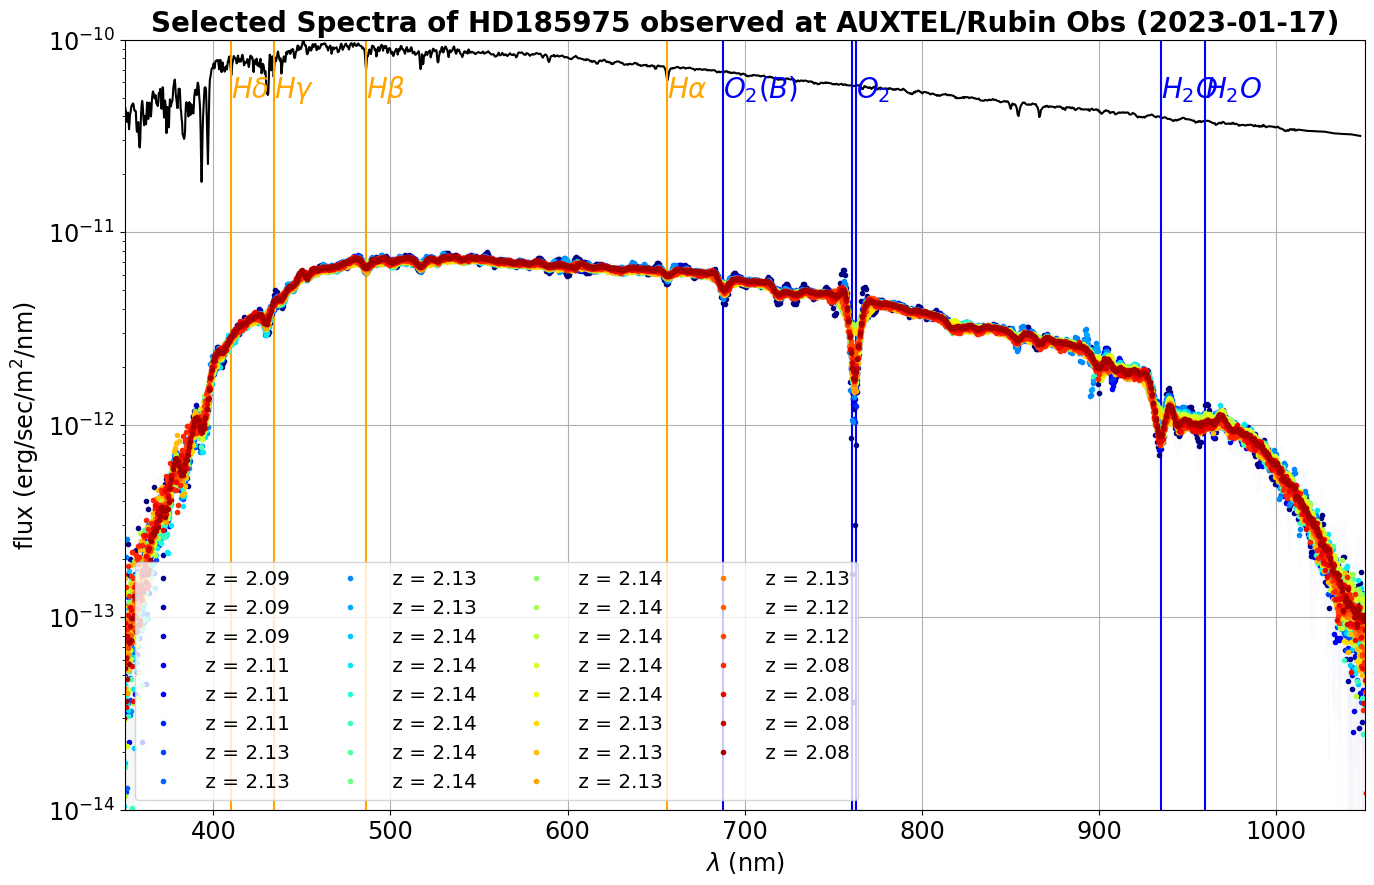

In [76]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=4)
#ax.legend(bbox_to_anchor=(1.02, 0.5))

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)


/Users/sylvie/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
2023-01-27 15:29:37,029 imacdagoret.lal.in2p3.fr matplotlib.legend[35856] WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.09 (236)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.09 (237)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.09 (238)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.11 (247)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.11 (248)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.11 (249)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.13 (295)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.13 (296)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.13 (297)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Excepti

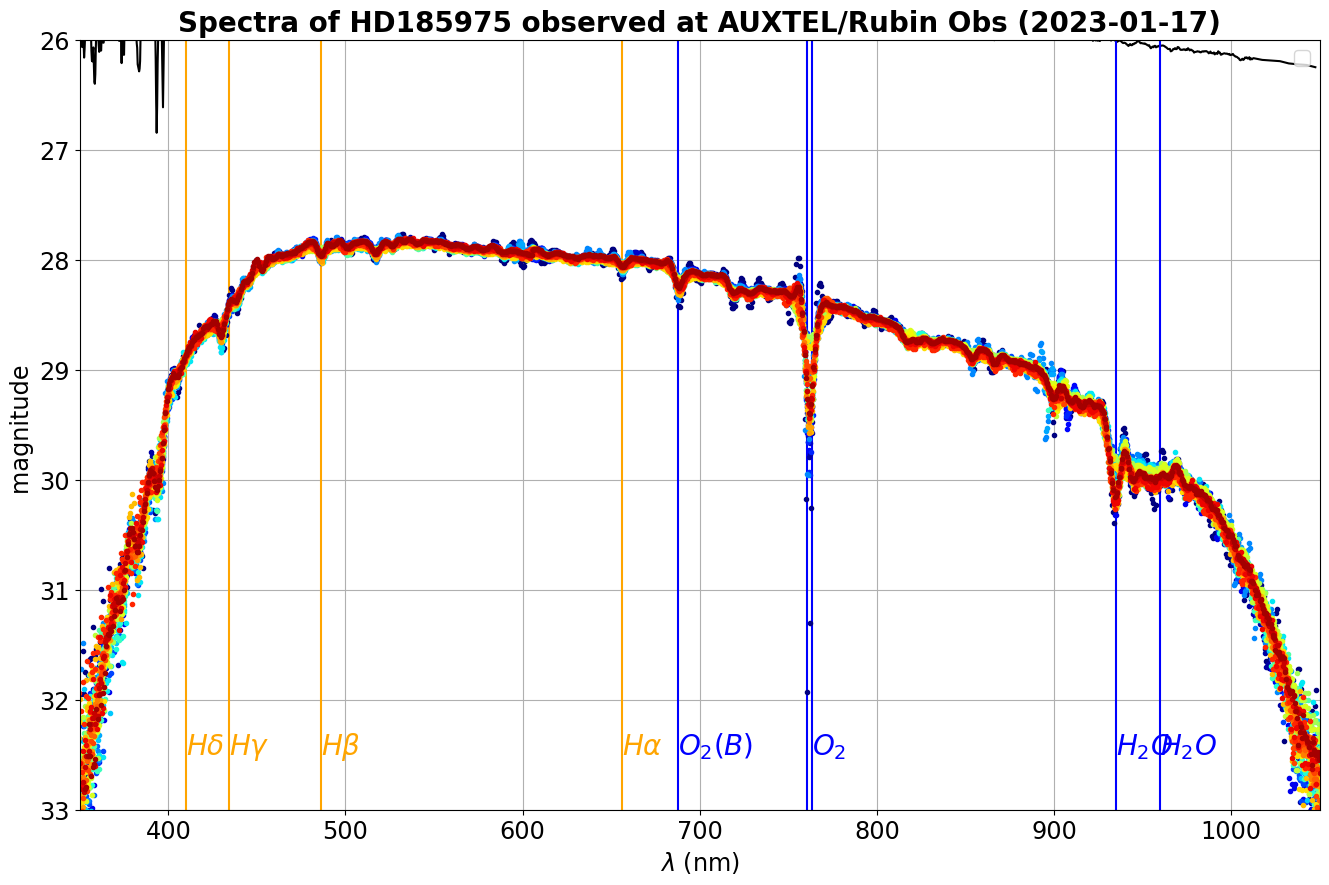

In [77]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"])
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    try:
        ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    except Exception as inst:
        print(type(inst))    # the exception instance
        print(inst.args)
        print(f"Exception ocurred at {label_airmass}")
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.invert_yaxis()
ax.legend(loc="upper right",ncol=4)
#ax.legend(bbox_to_anchor=(1.02, 0))

# draw abs lines
plotlines(ax,ypos=MAGLIMMAX-0.5)


2023-01-27 15:29:37,431 imacdagoret.lal.in2p3.fr matplotlib.legend[35856] WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.09 (236)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.09 (237)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.09 (238)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.11 (247)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.11 (248)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.11 (249)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.13 (295)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.13 (296)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.13 (297)
<class 'ValueError'>
("'yerr' must not contain negative values",)
Excepti

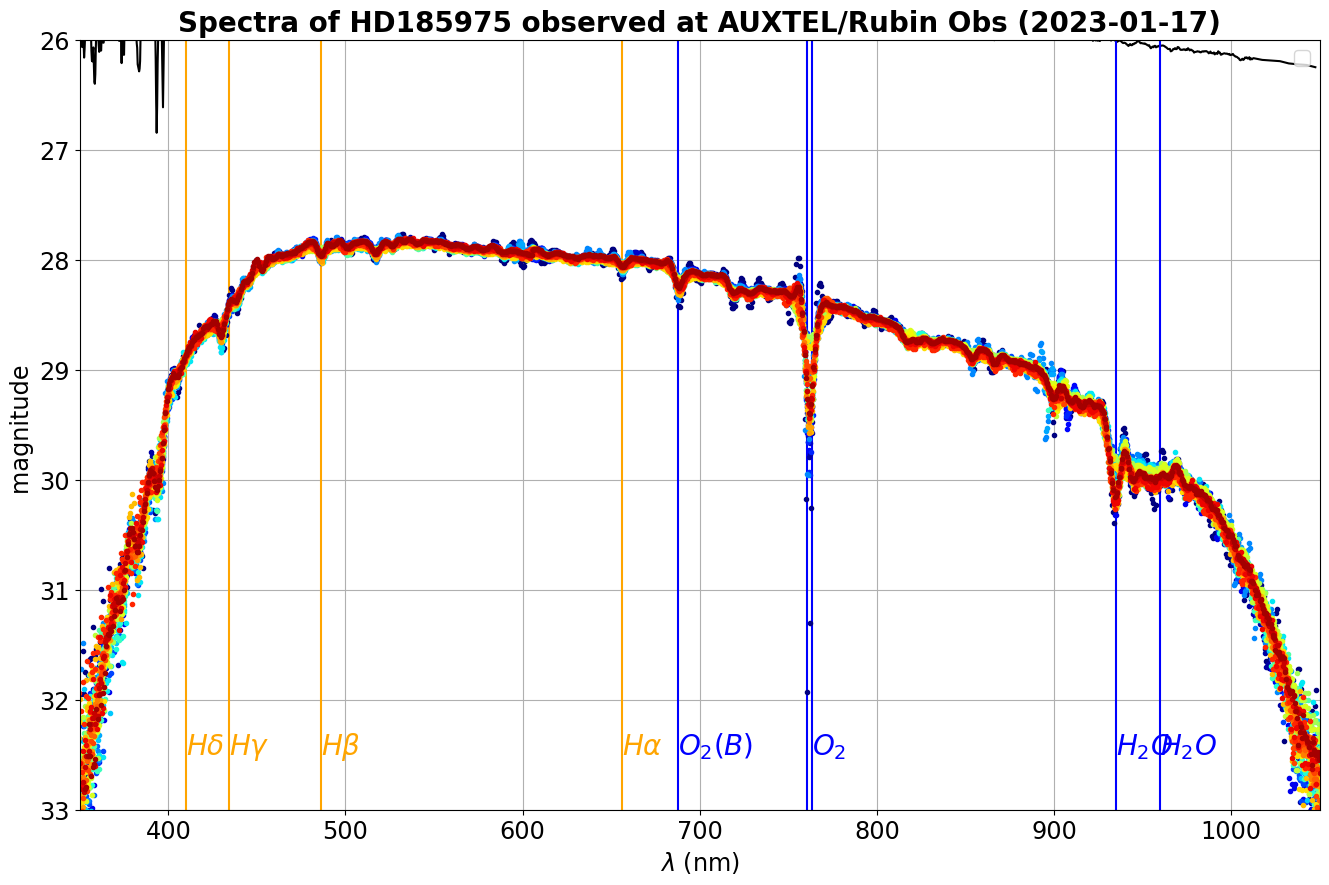

In [78]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"])
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    try:
        ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    except Exception as inst:
        print(type(inst))    # the exception instance
        print(inst.args)
        print(f"Exception ocurred at {label_airmass}")
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.invert_yaxis()
ax.legend(loc="upper right",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0))
# draw abs lines
plotlines(ax,ypos=MAGLIMMAX-0.5)

# Multiply SED by all throughput

In [79]:
correction_area = 1.06/1.13

In [80]:
sed_predicted_f = f_sed(WL) * f_thr(WL) * f_atm(WL) 
sed_predicted_m = -2.5*np.log10(sed_predicted_f) 

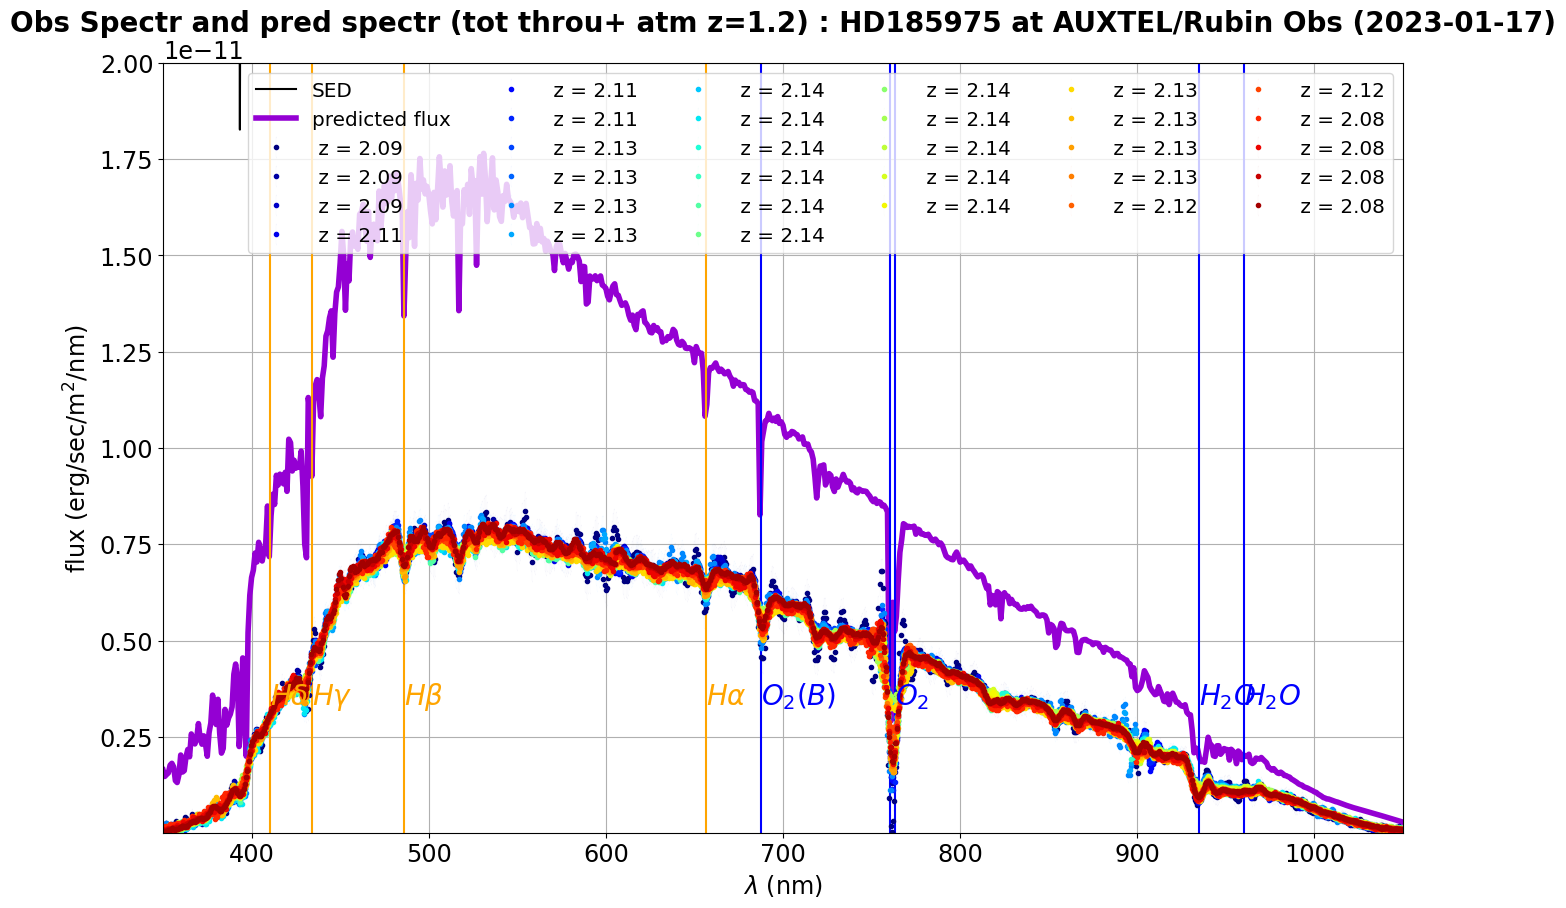

In [81]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Obs Spectr and pred spectr (tot throu+ atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-',label="SED")
ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX/5.)
#ax.set_yscale("log")
ax.legend(loc="upper right",ncol=6)


# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/30)



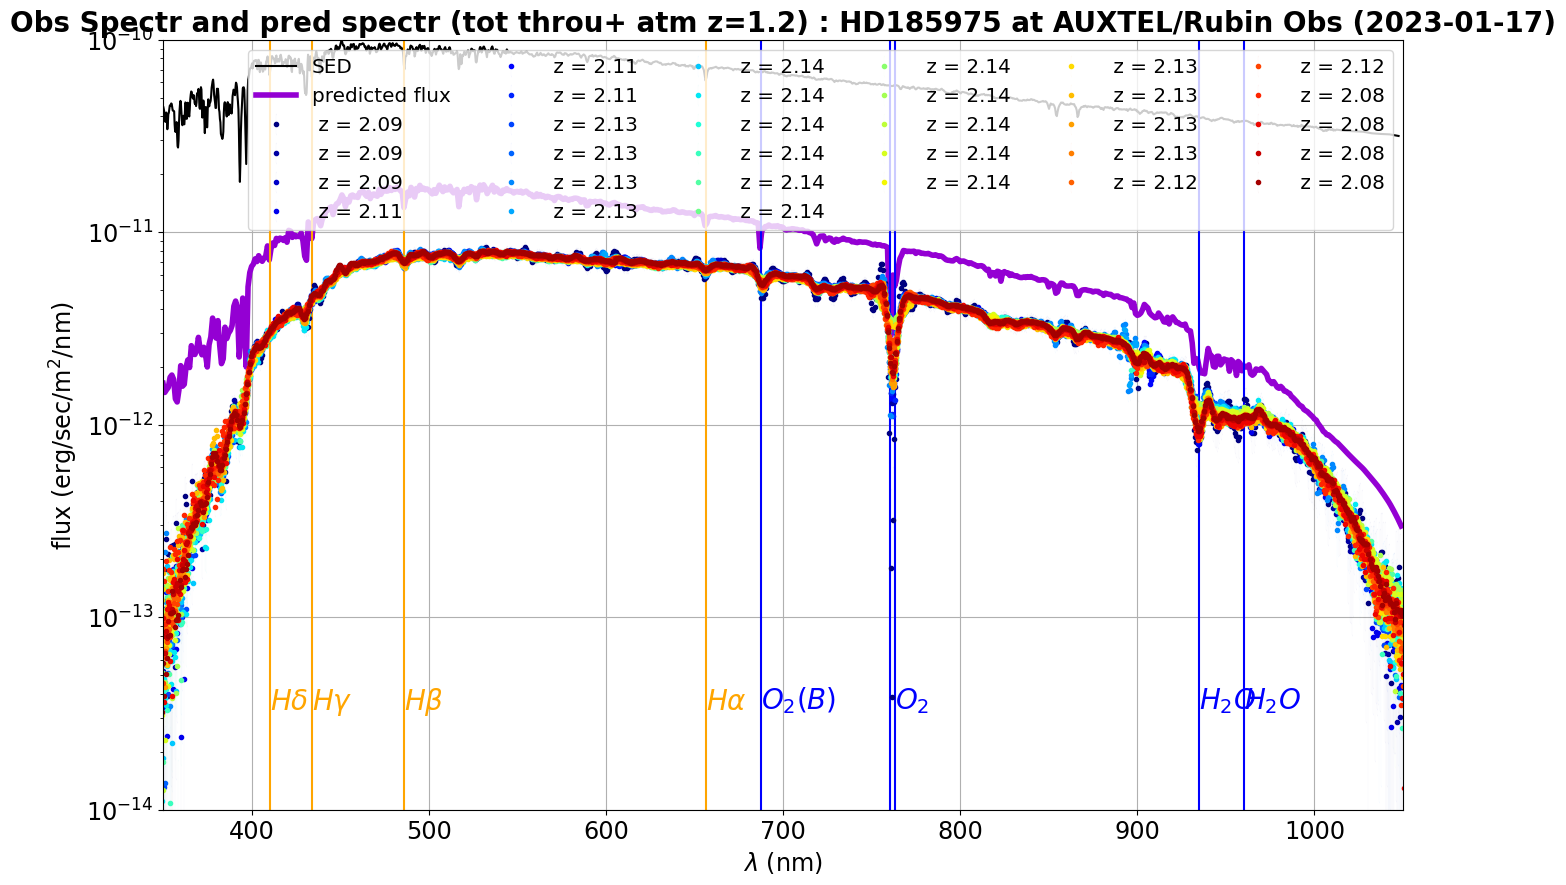

In [82]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Obs Spectr and pred spectr (tot throu+ atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-',label="SED")
ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=6)

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/3000)

<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.09
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.09
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.09
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.11
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.11
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.11
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.13
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.13
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.13
<class 'ValueError'>
("'yerr' must not contain negative values",)
Exception ocurred at  z = 2.13
<class 'ValueError'>
("'yerr' 

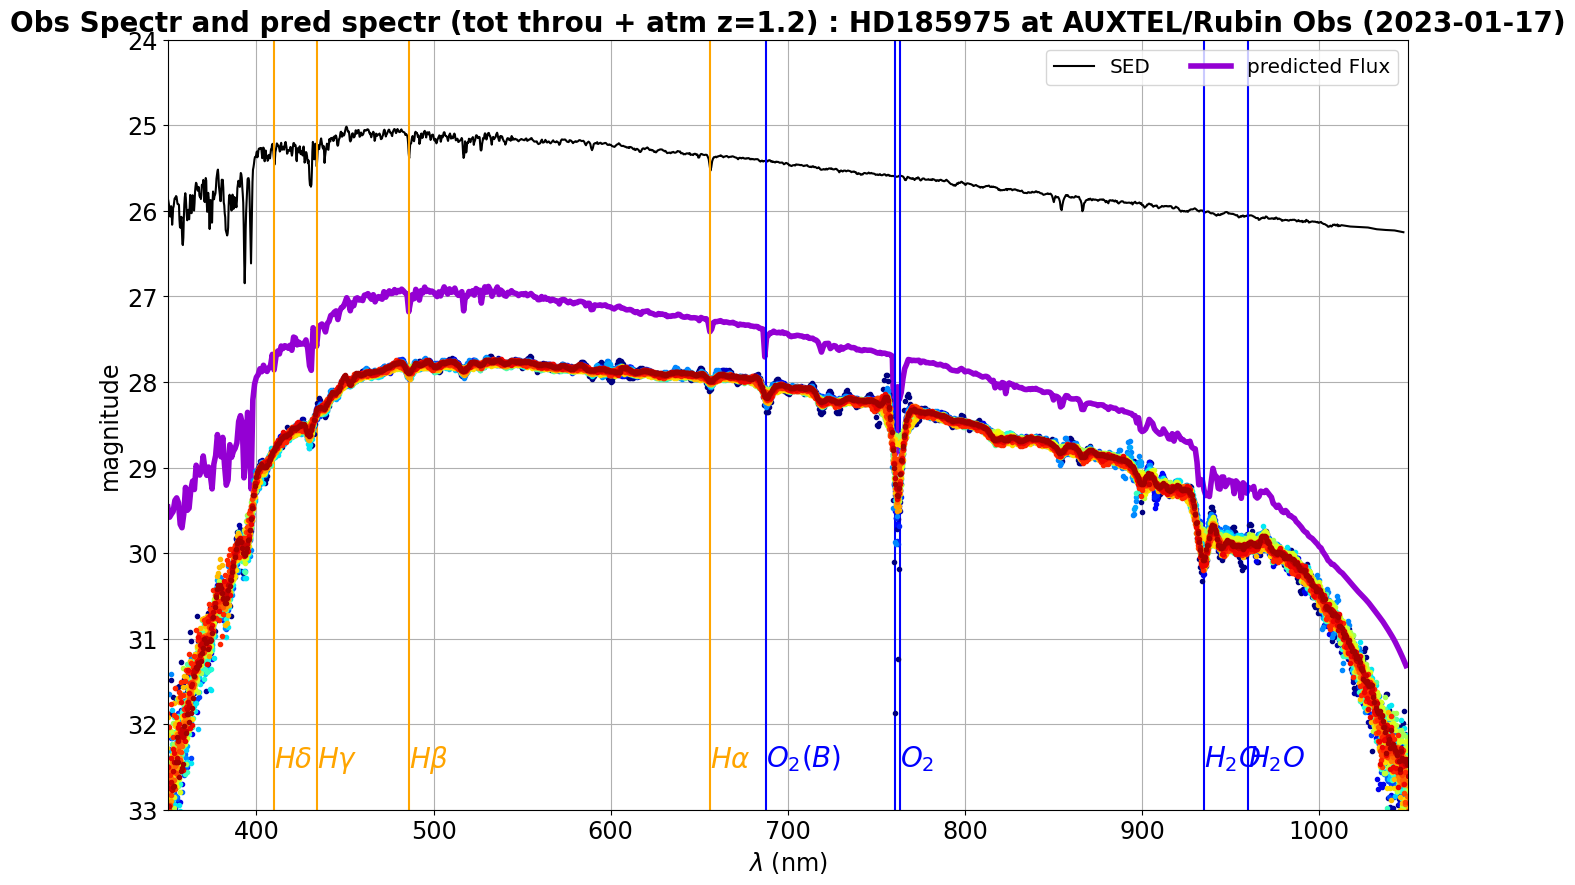

In [83]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"]/correction_area)
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    try:
        ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    except Exception as inst:
        print(type(inst))    # the exception instance
        print(inst.args)
        print(f"Exception ocurred at {label_airmass}")
    
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude")
title=f"Obs Spectr and pred spectr (tot throu + atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-',label = 'SED')
ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

ax.set_ylim(MAGLIMMIN-2.,MAGLIMMAX)
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

ax.invert_yaxis()

ax.legend(loc="upper right",ncol=5)

# draw abs lines
plotlines(ax,ypos=MAGLIMMAX-0.5)

In [84]:
assert False

AssertionError: 

# Filtering a line

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Pred spectr (tot throu+ atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-',label="SED")
ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)

# filtered flux
span = 3
sed_predicted_f_filtered = smooth_data_np_convolve(sed_predicted_f, span)
ax.plot(WL,sed_predicted_f_filtered/2,"-.",color='darkviolet',lw=4,label = "predicted flux filtered/2")


ax.set_yscale("log")
ax.legend(loc="upper right")


# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2000)

# Ratio

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

# input spectra
all_spectra_interp = []

for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    
    
    x=the_df["all_lambdas"]
    y=the_df['all_fluxes']/correction_area, 
    yerr=the_df["all_fluxes_err"]
    
    
    f = interpolate.interp1d(x, y,bounds_error=False,fill_value=0)
    fe = interpolate.interp1d(x, yerr,bounds_error=False,fill_value=0)
    y_interp =f(WL)[0]
    ey_interp = fe(WL)[0]
    
    
    
    ratio = y_interp/sed_predicted_f_filtered
    eratio = ey_interp/sed_predicted_f_filtered
    
    all_spectra_interp.append(y_interp)

    

    #if num == 87 or num == 330 or num == 331:
    ax.errorbar(WL,ratio,yerr=eratio, fmt = '-', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)

ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Ratio Obs Spectr and pred spectr (tot throu + atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_m,'k-',label = 'SED')
#ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

#ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.3,1.4)
ax.legend(loc="upper right",ncol=5)

# Make Simulation with true airmass & pressure

In [ ]:
infos

## Define PWV

In [ ]:
all_pwv = np.array([0., 4., 8. ])
NPWV = len(all_pwv)

### Header

- 0 : index of simulation
- 1 : index of spectra
- 2 : spectrum number
- 3 : airmass value
- 4 : pressure
- 5 : pwv
- 6 : aer
- 7 : ozone
- 8 : cloud extinction
- 9 : humidity
- 10 : start of sim

In [ ]:
ATM_VERSION = "v01"
IDX_SIM_IDX = 0
IDX_SPEC_IDX = 1
IDX_SPEC_NUM = 2
IDX_SPEC_AM = 3
IDX_WEATH_PRES = 4
IDX_WEATH_PWV = 5
IDX_WEATH_AER = 6
IDX_WEATH_OZON = 7
IDX_WEATH_CLD = 8
IDX_WEATH_HUM = 9
IDX_SIM_START = 10

In [ ]:
atmosphere_type="us"

In [ ]:
#atmsimfilename = f"atmsim-{DATE}-{filterdisperser}-{atmosphere_type}-{ATM_VERSION}.npy"
atmsimfilename = f"atmsim-{DATE}-{filterdisperser}-{atmosphere_type}-{target}-{ATM_VERSION}-{spectractormode}.npy"
atmsimfilename 

In [ ]:
FLAG_ATMSIMFILE = False
if os.path.isfile(atmsimfilename):
    FLAG_ATMSIMFILE = True    

In [ ]:
if not FLAG_ATMSIMFILE:
    atmsim = np.zeros((NBSPECTRA*NPWV+1,IDX_SIM_START + NBINSIM))
    atmsim[0, IDX_SIM_START:] = wlsim
    
    
    # loop on spectra

    idx_sim = 0

    for idx_spec in range(NBSPECTRA):
    
        print(f"atmospheric simulation for spectrum index : {idx_spec}")
    
        num = infos.iloc[idx_spec]["number"]
        # loop on pwv
        for pwv in all_pwv:
            am       = infos.iloc[idx_spec]["airmass"]
            pressure = infos.iloc[idx_spec]["pressure"]
            hum      = infos.iloc[idx_spec]["humidity"]
            aer      = 0
            ozone    = 300.
            cloudext = 0
    
    
            path,thefile=libsimulateVisible.ProcessSimulation(am,pwv,ozone,pressure,prof_str='us',proc_str='sa',cloudext=cloudext)
            data = np.loadtxt(os.path.join(path,thefile))
            wlsim = data[:,0]
            tratmsim = data[:,1]
        
        
            # counter on simulation from 1 to NBSPECTRA*NPWV
            idx_sim += 1
        
            ## fill array
            atmsim[idx_sim,IDX_SIM_IDX]    = idx_sim
            atmsim[idx_sim,IDX_SPEC_IDX]   = idx_spec
            atmsim[idx_sim,IDX_SPEC_NUM]   = num 
            atmsim[idx_sim,IDX_SPEC_AM]    = am
            atmsim[idx_sim,IDX_WEATH_PRES] = pressure
            atmsim[idx_sim,IDX_WEATH_PWV]  = pwv
            atmsim[idx_sim,IDX_WEATH_AER]  = aer
            atmsim[idx_sim,IDX_WEATH_OZON] = ozone
            atmsim[idx_sim,IDX_WEATH_CLD]  = cloudext
            atmsim[idx_sim,IDX_WEATH_HUM]  = hum
            atmsim[idx_sim,IDX_SIM_START:] = tratmsim
            
else:
    print(f"Load file {atmsimfilename}")
    atmsim = np.load(atmsimfilename)
    print(atmsim.shape)
        
        
    

In [ ]:
if not FLAG_ATMSIMFILE:
    np.save(atmsimfilename,atmsim)
    FLAG_ATMSIMFILE = True

In [ ]:
plt.imshow(atmsim[1:,IDX_SIM_START:],origin="lower", aspect='auto', extent = [ atmsim[0,IDX_SIM_START],atmsim[0,-1],0,NBSPECTRA*NPWV ])

# Compute ratio

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

all_ratio = []
all_num = []
all_label = []
all_airmass = []
all_date = []

all_spectra_sim_interp = []

for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    all_date = infos.iloc[ifile]["dateobs"]
    
    all_num.append(num)
    all_label.append(label_airmass)
    all_airmass.append(airmassvalue)
    
    # data
    x=the_df["all_lambdas"]
    y=the_df['all_fluxes']/correction_area
    yerr=the_df["all_fluxes_err"]/correction_area
    
    
    f = interpolate.interp1d(x, y,bounds_error=False,fill_value=0)
    fe = interpolate.interp1d(x, yerr,bounds_error=False,fill_value=0)
    y_interp =f(WL)
    ey_interp = fe(WL)
    
    # atmsim
    x0 = atmsim[0, IDX_SIM_START:]
    y0 = atmsim[ifile*NPWV+1 + 1  ,IDX_SIM_START:]
    f0_atm = interpolate.interp1d(x0,y0,bounds_error=False,fill_value="extrapolate")
    flux_predicted_f = f_sed(WL) * f_thr(WL) * f0_atm(WL) 
    span = 3
    flux_predicted_f_filtered = smooth_data_np_convolve(flux_predicted_f, span)
    
    all_spectra_sim_interp.append(flux_predicted_f_filtered ) 
    
    ratio = y_interp/flux_predicted_f_filtered
    eratio = ey_interp/flux_predicted_f_filtered
    

    #if num == 87 or num == 330 or num == 331:
    ax.errorbar(WL,ratio,yerr=eratio, fmt = '-', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    all_ratio.append(ratio)
        
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Ratio Obs Spectr and pred spectr at airmass: {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_m,'k-',label = 'SED')
#ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

#ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.3,1.4)
ax.legend(loc="upper right",ncol=5)

plotlines(ax,ypos=0.35)

# Find the upper curve for the ratio and calculate ratio of ratio to get grey attenuation

In [ ]:
indexes=np.where(np.logical_and(WL> 500,WL<650))[0]          

In [ ]:
average_ratio = np.array([ np.mean(ratio[indexes]) for ratio in  all_ratio])

### find top spectrum

In [ ]:
idx_max = np.where(average_ratio == average_ratio.max())[0][0]
ratio_max= all_ratio[idx_max]
label_ratio_max = all_label[idx_max]
spec_max  = all_spectra_interp[idx_max]

### Lowest spectrum

In [ ]:
idx_min = np.where(average_ratio == average_ratio.min())[0][0]
ratio_min= all_ratio[idx_min]
label_ratio_min = all_label[idx_min]
label_ratio_min
spec_min  = all_spectra_interp[idx_min]

In [ ]:
all_airmass=np.array(all_airmass)
idx_zmin = np.where(all_airmass==all_airmass.min())[0][0]
ratio_zmin= all_ratio[idx_zmin]
label_ratio_zmin = all_label[idx_zmin]
spec_zmin = all_spectra_interp[idx_zmin]

In [ ]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
ax.plot(WL,ratio_max,'b-',label=label_ratio_max)
ax.plot(WL,ratio_min,'g-',label=label_ratio_min)
ax.plot(WL,all_ratio[idx_zmin],'k-',label=label_ratio_zmin)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.3,1.4)
ax.legend(loc="upper right",ncol=2)

# Work with Pairs

## Pairs at simular airmass

In [ ]:
dfpair = FindPairOfExposures(infos)
dfpair

In [ ]:
rank=0
idx1_pair = int(dfpair.iloc[rank]["idx1"])
idx2_pair = int(dfpair.iloc[rank]["idx2"])
spec_pair_1  = all_spectra_interp[idx1_pair]/average_ratio[idx1_pair]
spec_pair_2  = all_spectra_interp[idx2_pair]/average_ratio[idx2_pair]

specsim_pair_1 = all_spectra_sim_interp[idx1_pair]
specsim_pair_2 = all_spectra_sim_interp[idx2_pair]

z1 = dfpair.iloc[rank]["z1"]
z2 = dfpair.iloc[rank]["z2"]
dt = dfpair.iloc[rank]["dtime"]
num1 = int(dfpair.iloc[rank]["num1"])
num2 = int(dfpair.iloc[rank]["num2"])

In [ ]:
span=15
#ratio_spectra=spec_pair_2/spec_pair_1
#ratio_spectrasim=specsim_pair_2/specsim_pair_1
#ratio_spectra_smoo = smooth_data_np_convolve(ratio_spectra, span)
#ratio_spectrasim_smoo = smooth_data_np_convolve(ratio_spectrasim, span)

ratio_spectra_smoo = smooth_data_np_convolve(spec_pair_2, span)/smooth_data_np_convolve(spec_pair_1, span)
ratio_spectrasim_smoo = smooth_data_np_convolve(specsim_pair_2, span)/smooth_data_np_convolve(specsim_pair_1, span)

ax = None
fig=plt.figure(figsize=(10,6))
#plt.plot(WL,ratio_spectra,color="grey",alpha=0)

plt.plot(WL,ratio_spectra_smoo,"r-",lw=3,label="smoothed spectr data") 
plt.plot(WL,ratio_spectrasim_smoo,"b-",lw=3,label="smoothed spec sim") 
plt.grid()
plt.legend(loc="lower center")
plt.ylim(0.8,1.2)
#plt.xlim(WLMINSEL+span,WLMAXSEL-span)
plt.xlim(380,700)
#title = f"z1={z1:.2f}, z2={z2:.2f}, dt={dt:.1f}"
title=f"Ratio Obs Spectr different airmasses: {target} at {SITE} ({DATE})"

plt.title(title)

textstr = '\n'.join((
    r'$z_1=%.2f$ - (#%.d)' % (z1,num1 ),
    r'$z_2=%.2f$ - (#%.d)' % (z2,num2 ),
    r'$\Delta t=%.2f$ hours' % (dt, )))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
if not ax:
    ax = plt.gca()
ax.text(0.1, 0.9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plotlines(ax,ypos=0.9)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
plt.show()

In [ ]:
all_smoothed_ratios_data = []
all_smoothed_ratios_sim = []
all_dt = []
all_labels=[]

NF = len(dfpair)
NC=4
NR=int(np.ceil(NF/NC))
fig=plt.figure(figsize=(NC*10,6*NR))


for irank in range(len(dfpair)):
    
    ax=fig.add_subplot(NR,NC,irank+1)
    
    idx1_pair = int(dfpair.iloc[irank]["idx1"])
    idx2_pair = int(dfpair.iloc[irank]["idx2"])
    spec_pair_1  = all_spectra_interp[idx1_pair]/average_ratio[idx1_pair]
    spec_pair_2  = all_spectra_interp[idx2_pair]/average_ratio[idx2_pair]
    specsim_pair_1 = all_spectra_sim_interp[idx1_pair]
    specsim_pair_2 = all_spectra_sim_interp[idx2_pair]
    z1 = dfpair.iloc[irank]["z1"]
    z2 = dfpair.iloc[irank]["z2"]
    dt = dfpair.iloc[irank]["dtime"]
    num1 = int(dfpair.iloc[irank]["num1"])
    num2 = int(dfpair.iloc[irank]["num2"])
    
    span=15
    #ratio_spectra=spec_pair_2/spec_pair_1
    #ratio_spectrasim=specsim_pair_2/specsim_pair_1
    #ratio_spectra_smoo = smooth_data_np_convolve(ratio_spectra, span)
    #ratio_spectrasim_smoo = smooth_data_np_convolve(ratio_spectrasim, span)
    
    ratio_spectra_smoo = smooth_data_np_convolve(spec_pair_2, span)/smooth_data_np_convolve(spec_pair_1, span)
    ratio_spectrasim_smoo = smooth_data_np_convolve(specsim_pair_2, span)/smooth_data_np_convolve(specsim_pair_1, span)
    
    all_smoothed_ratios_data.append(ratio_spectra_smoo)
    all_smoothed_ratios_sim.append(ratio_spectrasim_smoo)
    all_dt.append(dt) 
    
    
    #ax.plot(WL,ratio_spectra,color="grey",alpha=0)
    ax.plot(WL,ratio_spectra_smoo,"r-",lw=3,label="smoothed spectr-ratio data : spec2/spec1") 
    ax.plot(WL,ratio_spectrasim_smoo,"b-",lw=3,label="smoothed spectr-ratio sim (no aerosol)") 
    ax.grid()
    ax.legend(loc='lower center')
    
    ymin=0.9
    ymax=1.1
    yscale=ymax-ymin
    
    
    ax.set_ylim(ymin,ymax)
    #ax.set_xlim(WLMINSEL+span,WLMAXSEL-span)
    ax.set_xlim(380,700)
    title = f"z1={z1:.2f}, z2={z2:.2f}, dt={dt:.1f}"
    title = f"pair {irank+1}"
    
    textstr = '\n'.join((
    r'$z_1=%.2f$ - (#%.d)' % (z1,num1 ),
    r'$z_2=%.2f$ - (#%.d)' % (z2,num2 ),
    r'$\Delta t=%.2f$ hours' % (dt, )))
    
    label = f"$z_2$={z2:.2f} / $z_1$={z1:.2f} $\delta$t={dt:.2f}h"
    all_labels.append(label)
    
    ax.set_title(title)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.1, 0.9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    plotlines(ax,ypos=ymin+yscale/8)
    ax.set_xlabel("$\lambda$ (nm)")
    
suptitle=f"Ratio Obs Spectr different airmasses: {target} at {SITE} ({DATE}), rec mode = {spectractormode}"
plt.suptitle(suptitle,fontsize=18,Y=1.01)
plt.tight_layout()
plt.show()
    
    

In [ ]:
#all_smoothed_ratios_data 
#all_smoothed_ratios_sim 
all_dt=np.array(all_dt)
N=len(all_dt)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=all_dt.min(), vmax=all_dt.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)

for idx in range(N):
    the_color = scalarMap.to_rgba(all_dt[idx], alpha=1)
    dt=all_dt[idx]
    ax.plot(WL,all_smoothed_ratios_data[idx],"-",color=the_color,lw=3,label=all_labels[idx]) 
    #ax.plot(WL,all_smoothed_ratios_sim[idx] ,"-",color=the_color) 
    ax.fill_between(WL,y1=1,y2=all_smoothed_ratios_sim[idx] ,color=the_color,alpha=0.1) 
ax.grid()
ymin=0.9
ymax=1.1
yscale=ymax-ymin
ax.set_ylim(0.9,1.1)
ax.set_xlim(380,700)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
ax.legend(ncol=3)
title=f"Ratio : {target} at {SITE} ({DATE}), {filterdisperser}, spectractor:{spectractormode}"
ax.set_title(title)
plotlines(ax,ypos=ymin+yscale/8.)

### Pairs from First

In [ ]:
df1,df2,dfpair = FindPairOfExposuresFromFirst(infos)

In [ ]:
rank=len(dfpair)-1
idx1_pair = int(dfpair.iloc[rank]["idx1"])
idx2_pair = int(dfpair.iloc[rank]["idx2"])
spec_pair_1  = all_spectra_interp[idx1_pair]/average_ratio[idx1_pair]
spec_pair_2  = all_spectra_interp[idx2_pair]/average_ratio[idx2_pair]

specsim_pair_1 = all_spectra_sim_interp[idx1_pair]
specsim_pair_2 = all_spectra_sim_interp[idx2_pair]

z1 = dfpair.iloc[rank]["z1"]
z2 = dfpair.iloc[rank]["z2"]
dt = dfpair.iloc[rank]["dtime"]
num1 = int(dfpair.iloc[rank]["num1"])
num2 = int(dfpair.iloc[rank]["num2"])

In [ ]:
span=15

#ratio_spectra=spec_pair_2/spec_pair_1
#ratio_spectrasim=specsim_pair_2/specsim_pair_1
#ratio_spectra_smoo = smooth_data_np_convolve(ratio_spectra, span)
#ratio_spectrasim_smoo = smooth_data_np_convolve(ratio_spectrasim, span)

ratio_spectra_smoo = smooth_data_np_convolve(spec_pair_2, span)/smooth_data_np_convolve(spec_pair_1, span)
ratio_spectrasim_smoo = smooth_data_np_convolve(specsim_pair_2, span)/smooth_data_np_convolve(specsim_pair_1, span)


ax = None
fig=plt.figure(figsize=(10,6))
#plt.plot(WL,ratio_spectra,color="grey",alpha=0.5)
plt.plot(WL,ratio_spectra_smoo,"r-",lw=3,label="smoothed spectr data") 
plt.plot(WL,ratio_spectrasim_smoo,"b-",lw=3,label="smoothed spec sim (Rayleigh, no aerosols)") 
plt.grid()
plt.legend()
plt.ylim(0.8,1.2)
plt.xlim(380,700)
#title = f"z1={z1:.2f}, z2={z2:.2f}, dt={dt:.1f}"
title=f"Ratio Obs Spectr different airmasses: {target} at {SITE} ({DATE})"

plt.title(title)

textstr = '\n'.join((
    r'$z_1=%.2f$ - (#%.d)' % (z1,num1 ),
    r'$z_2=%.2f$ - (#%.d)' % (z2,num2 ),
    r'$\Delta t=%.2f$ hours' % (dt, )))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
if not ax:
    ax = plt.gca()
ax.text(0.1, 0.9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plotlines(ax,ypos=0.85)
plt.show()

In [ ]:
all_smoothed_ratios_data = []
all_smoothed_ratios_sim = []
all_dt = []
all_labels=[] 

NF = len(dfpair)
NC=4
NR=int(np.ceil(NF/NC))
fig=plt.figure(figsize=(NC*10,6*NR))


for irank in range(len(dfpair)):
    
    ax=fig.add_subplot(NR,NC,irank+1)
    
    idx1_pair = int(dfpair.iloc[irank]["idx1"])
    idx2_pair = int(dfpair.iloc[irank]["idx2"])
    spec_pair_1  = all_spectra_interp[idx1_pair]/average_ratio[idx1_pair]
    spec_pair_2  = all_spectra_interp[idx2_pair]/average_ratio[idx2_pair]
    specsim_pair_1 = all_spectra_sim_interp[idx1_pair]
    specsim_pair_2 = all_spectra_sim_interp[idx2_pair]
    z1 = dfpair.iloc[irank]["z1"]
    z2 = dfpair.iloc[irank]["z2"]
    dt = dfpair.iloc[irank]["dtime"]
    num1 = int(dfpair.iloc[irank]["num1"])
    num2 = int(dfpair.iloc[irank]["num2"])
    
    
    
    
    
     # Smooth and compute ratio
    span=15
    #ratio_spectra=spec_pair_2/spec_pair_1
    #ratio_spectrasim=specsim_pair_2/specsim_pair_1
    #ratio_spectra_smoo = smooth_data_np_convolve(ratio_spectra, span)
    #ratio_spectrasim_smoo = smooth_data_np_convolve(ratio_spectrasim, span)
    
    ratio_spectra_smoo = smooth_data_np_convolve(spec_pair_2, span)/smooth_data_np_convolve(spec_pair_1, span)
    ratio_spectrasim_smoo = smooth_data_np_convolve(specsim_pair_2, span)/smooth_data_np_convolve(specsim_pair_1, span)
    
    all_smoothed_ratios_data.append(ratio_spectra_smoo)
    all_smoothed_ratios_sim.append(ratio_spectrasim_smoo)
    
    all_dt.append(dt) 
    
    
    #ax.plot(WL,ratio_spectra,color="grey",alpha=0)
    ax.plot(WL,ratio_spectra_smoo,"r-",lw=3,label="smoothed spectr-ratio data : spec2/spec1") 
    ax.plot(WL,ratio_spectrasim_smoo,"b-",lw=3,label="smoothed spectr-ratio sim (Rayleigh,no aerosol)") 
    ax.grid()
    ax.legend(loc='lower center')
    ymin=0.8
    ymax=1.2
    ax.set_ylim(ymin,ymax)
    #ax.set_xlim(WLMINSEL+span,WLMAXSEL-span)
    ax.set_xlim(380.,700.)
    ax.set_xlabel("$\lambda$ (nm)")
    title = f"z1={z1:.2f}, z2={z2:.2f}, dt={dt:.1f}"
    title = f"pair {irank+1}"
   
    textstr = '\n'.join((
    r'$z_1=%.2f$ - (#%.d)' % (z1,num1 ),
    r'$z_2=%.2f$ - (#%.d)' % (z2,num2 ),
    r'$\Delta t=%.2f$ hours' % (dt, )))
    label = f"$z_2$={z2:.2f} / $z_1$={z1:.2f} $\delta$t={dt:.2f}h"
    all_labels.append(label)
    
    ax.set_title(title)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.1, 0.9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    plotlines(ax,ypos=ymin+yscale/8)
suptitle=f"Ratio Obs Spectr different airmasses: {target} at {SITE} ({DATE}), rec mode = {spectractormode}"
plt.suptitle(suptitle,fontsize=18,Y=1.01)
plt.tight_layout()
plt.show()
    
    

In [ ]:
#all_smoothed_ratios_data 
#all_smoothed_ratios_sim 
all_dt=np.array(all_dt)
N=len(all_dt)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=all_dt.min(), vmax=all_dt.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

fig=plt.figure(figsize=(16,8))
#fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)

for idx in range(N):
    the_color = scalarMap.to_rgba(all_dt[idx], alpha=1)
    dt=all_dt[idx]
    ax.plot(WL,all_smoothed_ratios_data[idx],"-",color=the_color,lw=3,label=all_labels[idx]) 
    #ax.plot(WL,all_smoothed_ratios_sim[idx] ,"-",color=the_color) 
    ax.fill_between(WL,y1=1,y2=all_smoothed_ratios_sim[idx] ,color=the_color,alpha=0.1) 
ax.grid()
ymin=0.6
ymax=1.4
yscale=ymax-ymin
ax.set_ylim(ymin,ymax)
#ax.set_xlim(370,1000)
ax.set_xlim(380,700)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
ax.legend(ncol=4,loc="upper right",fontsize=10)
title=f"Ratio : {target} at {SITE} ({DATE}), {filterdisperser}, spectractor mode: {spectractormode}"
ax.set_title(title)
plotlines(ax,ypos=ymin+yscale/8.)

# Ratio of Obsrved Spectra by max spectrum

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

all_ratioofratio = []

for ifile in np.arange(NBSPECTRA):
 
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    
     
    ratio = all_ratio[ifile]/ratio_max
    all_ratioofratio.append(ratio)
      
    ax.plot(WL,ratio, '-', color=all_colors[ifile],label=label_airmass)

  
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Ratio of ratio Obs Spectr and pred spectr at airmass: {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_m,'k-',label = 'SED')
#ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

#ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.3,1.4)
ax.legend(loc="upper right",ncol=5)

plotlines(ax,ypos=0.35)

In [ ]:
grey_attenuation =  np.array([ np.mean(ratio[indexes]) for ratio in  all_ratioofratio])

In [ ]:
len(grey_attenuation)

In [ ]:
plt.hist(1-grey_attenuation,bins=50,range=(0,0.5));
plt.xlabel("grey attenuation")

In [ ]:
infos["airmass"].values

In [ ]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['dateobs'] ]
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(111)
ax.plot(all_datetime,grey_attenuation,'bo:')
ax.grid()
#plt.gcf().autofmt_xdate()
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("time (UTC)")
ax.set_title(f"Grey attenuation : {DATE} ({filterdisperser}, {target})")
ax.set_ylabel("attenuation")
ax2 = ax.twinx() 
ax2.plot(all_datetime,infos["airmass"].values,'r:o')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.invert_yaxis()

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

all_ratio_nogreyatt = []
all_airmass = []


for ifile in np.arange(NBSPECTRA):
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    all_airmass.append(airmassvalue)
    
    ratio = all_ratio[ifile]/grey_attenuation[ifile]
    
    

    #if num == 87 or num == 330 or num == 331:
    ax.plot(WL,ratio,'-', color=all_colors[ifile],label=label_airmass)

    all_ratio_nogreyatt.append(ratio)
    
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Ratio Obs Spectr and pred spectr at airmass corr grey att: {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_m,'k-',label = 'SED')
#ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

#ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.3,1.4)
ax.legend(loc="upper right",ncol=5)

rect=mpl.patches.Rectangle((410,0.3),15,1.4,color ='yellow',alpha=0.3)
ax.add_patch(rect)

plotlines(ax,ypos=0.35)

In [ ]:
indexes2=np.where(np.logical_and(WL> 410,WL<425))[0]   
indexes3=np.where(np.logical_and(WL> 440,WL<450))[0]   

In [ ]:
att_aer2 = np.array([ np.median(ratio[indexes2])  for ratio in all_ratio_nogreyatt ])
att_aer3 = np.array([ np.median(ratio[indexes3])  for ratio in all_ratio_nogreyatt ])

In [ ]:
plt.plot(all_airmass,att_aer2,'ob')

In [ ]:
plt.plot(all_airmass,att_aer3,'og')